<a href="https://colab.research.google.com/github/argennof/DeepLearning2022_UNC/blob/main/blblb%C3%B1ln%C3%B1n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 5: Redes Neuronales Recurrentes

**Practica 5 - Estudiantes:**
   - [x] Andrés Solarte
   - [x] Dalma Bilbao
   - [x] Diana Fonnegra

## Predicción de señales sinusoidales usando redes neuronales recurrentes

En este ejemplo vamos a utilizar una red neuronal recurrente (RNN) para predecir cómo continuará una señal senoidal en el futuro, en base a observaciones pasadas.


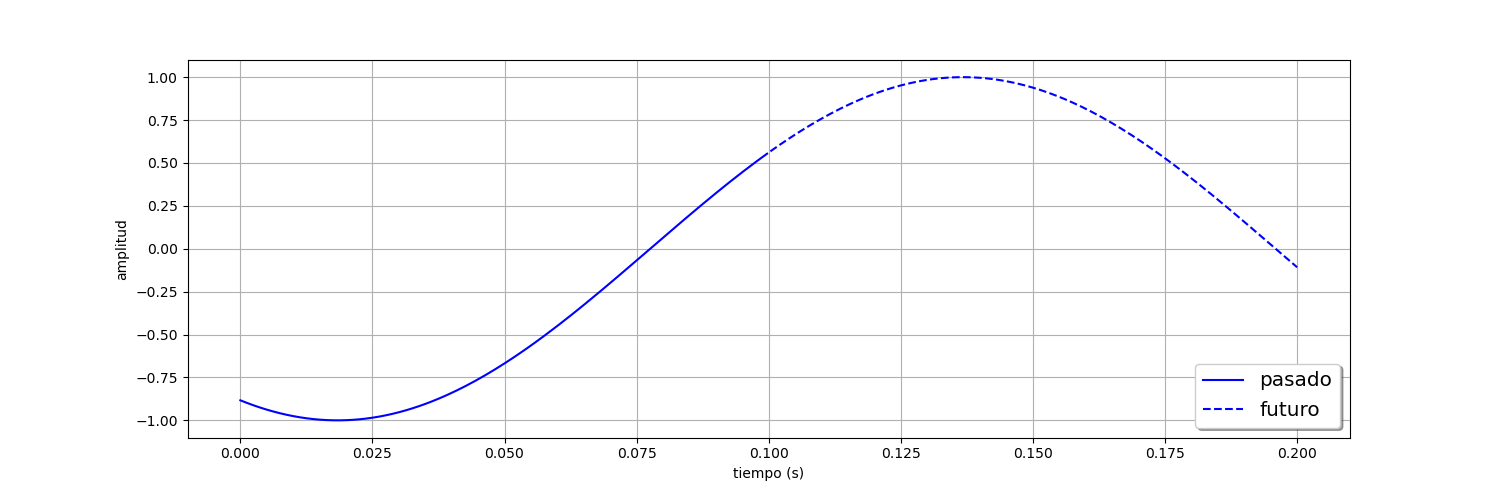

In [ ]:
# Importamos bibliotecas
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

### Construyendo la base de datos

Lo primero que hacemos es crear una base de datos sintética de señales sinusoidales de distintas frecuencias y fases.

In [ ]:
# Definimos el rango de frecuencias para nuestras señales [f_min,f_max] (en Hz)
f_min = 10
f_max = 50

# Luego definimos el paso dt y el tiempo total T (en s) para las señales completas (pasado y futuro)
# Quermos poder representar correctamente las señales más lentas y las más rápidas. 
# Elegimos valores razonables a tal fin:

dt = 1./(32.*f_max) # Paso
T = 0.75 / (f_min) # Longitud de la señal

# Eso determina el número de pasos temporales en la señal
n_steps = int(T/dt) #120 posiciones
ts = np.linspace(start=0, stop = 0.05, num= n_steps) 


In [ ]:
# Construimos entonces nuestros datos: señales sinusoidales de frecuencia y fase aleatorias

n_total = 1000

signals = np.empty([n_total,n_steps])

for i in range(len(signals)):
    f = f_min + (f_max-f_min) * np.random.rand()
    phase = 2 * np.pi * np.random.rand()
    signals[i] = np.sin(phase + 2*np.pi*f*ts)

120

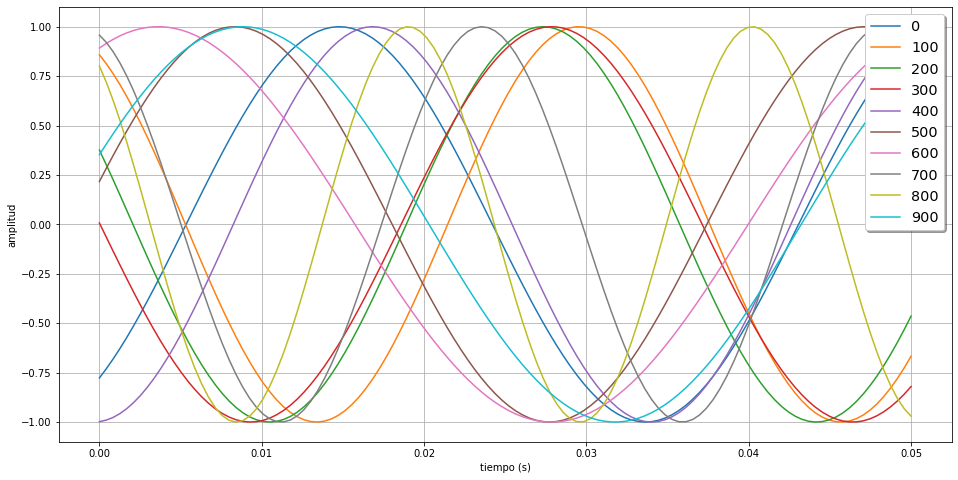

In [ ]:
# Les pegamos una mirada
fig, ax = plt.subplots(figsize=(16,8))

for i in range(0,n_total,100):
    ax.plot(ts , signals[i],label=str(i))

ax.set(xlabel='tiempo (s)', ylabel='amplitud')

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

ax.grid()

plt.show()

Queremos aprender a predecir el futuro de la señal (cómo sigue) en base a una observación pasada. Vamos a tender dos etapas en este problema:

a) Predecir el futuro inmediato (justo después de la señal de entrada)
b) Predecir el futuro remoto (más adelante en el tiempo)

Queremos hacer las dos cosas usando la misma red. Es decir, sin entrenar dos veces.

In [ ]:
# Partimos las señales en tres:
# pasado, futuro inmediato, y futuro remoto
seq_len = n_steps//3
x = signals[:,:seq_len]          # Pasado
y = signals[:,seq_len:-seq_len]  # Futuro inmediato
z = signals[:,-seq_len:]         # Futuro remoto

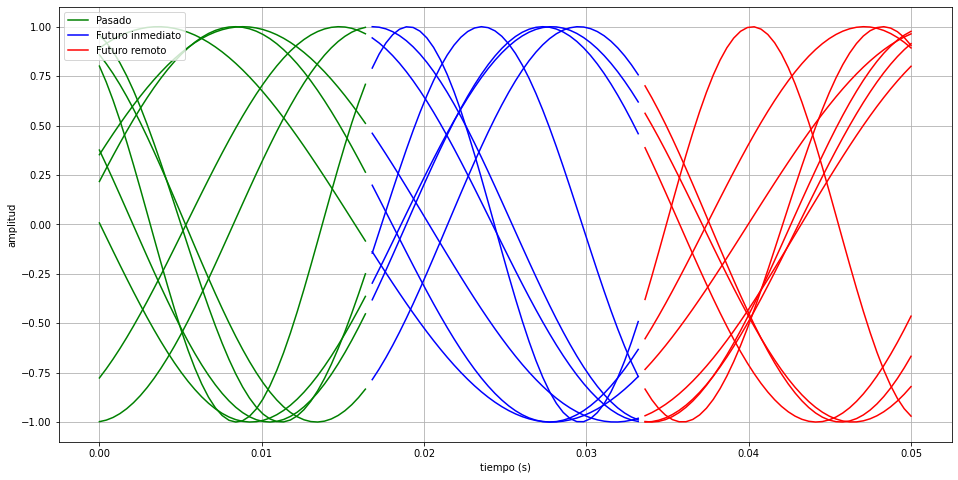

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

ts_x = ts[:seq_len]
ts_y = ts[seq_len:-seq_len]
ts_z = ts[-seq_len:]

for i in range(0,n_total,100):
    ax.plot(ts_x, x[i], color='green', label='Pasado')
    ax.plot(ts_y, y[i], color='blue', label='Futuro inmediato')
    ax.plot(ts_z, z[i], color='red', label='Futuro remoto')

ax.set(xlabel='tiempo (s)', ylabel='amplitud')

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), loc=2)

ax.grid()

plt.show()

In [ ]:
# Definimos un Dataset de Pytorch
class SignalDataset(Dataset):
    def __init__(self, X, Y):
        if not torch.is_tensor(X):
            self.X = torch.Tensor(X)
        if not torch.is_tensor(Y):
            self.Y = torch.Tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

## Parte a) Futuro Cercano

Usamos la primera parte de la señal como pasado (entrada a la red), y la segunda parte como target (salida deseada de la red). Además vamos a partir los datos en train, validation y test.

In [ ]:
y[train_idxs]

array([[ 0.93629717,  0.89746173,  0.85002212, ..., -0.66630583,
        -0.59018666, -0.50840922],
       [ 0.19264001,  0.28237629,  0.36970246, ..., -0.45443906,
        -0.5347069 , -0.61041096],
       [-0.91525558, -0.86428303, -0.80239922, ...,  0.13780604,
         0.0258245 , -0.08648307],
       ...,
       [-0.98368437, -0.97336826, -0.96057856, ...,  0.45777917,
         0.50200196,  0.54494902],
       [-0.85533888, -0.91119273, -0.95394869, ...,  0.72995963,
         0.64291464,  0.54662812],
       [-0.82764814, -0.75361648, -0.66849945, ..., -0.36508983,
        -0.47510799, -0.57813752]])

In [ ]:
# Partimos los datos en Train, Validation, y Test
batch_size = 20
perc_val = 0.2
perc_test = 0.2

n_val = int(perc_val*n_total)
n_test = int(perc_test*n_total)
n_train = n_total - n_val - n_test

s_idxs = np.arange(n_total)
np.random.shuffle(s_idxs)

#Vectores de índices aleatorizados
train_idxs = s_idxs[:n_train]
val_idxs = s_idxs[n_train:n_train+n_val]
test_idxs = s_idxs[-n_test:]
train_set = SignalDataset(x[train_idxs], y[train_idxs])
validation_set = SignalDataset(x[val_idxs], y[val_idxs])
test_set = SignalDataset(x[test_idxs], y[test_idxs])

print(train_set.X.size())

# Generamos dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False, num_workers=2)

torch.Size([600, 40])


### Seleccionamos GPU si está disponible

In [ ]:
# Eligiendo dispositivo (se puede cambiar en notebook settings)
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU disponible")
else:
    device = torch.device("cpu")
    print("GPU no disponible, usando CPU")

GPU disponible


### Definimos la RNN

Armamos una RNN donde la predicción se realiza solamente utilizando el estado final de la red recurrente. Si lo logra, toda la información relevante para el problema habrá sido almacenada en la red.

In [ ]:
class Model(nn.Module):
    def __init__(self, hidden_dim, seq_len):
        super(Model, self).__init__()

        # Definimos parámetros
        self.input_size = 1
        self.hidden_dim = hidden_dim
        self.n_layers = 1

        # Definimos capas

        # Una capa RNN
        self.rnn = nn.RNN(input_size = self.input_size, hidden_size = self.hidden_dim, 
                          num_layers = self.n_layers, batch_first=True)
        # x - > (batchsize, seq, inputsize) dado que estamos con vectores, x - > (batchsize, seq)
        
        # Y una capa completamente conectada
        self.fc = nn.Linear(self.hidden_dim, seq_len) # ojo con seq_len 
            
    def forward(self, x):
        
        batch_size = x.size(0)
        
        # Inicializamos las variables ocultas de la RNN
        hidden = self.init_hidden(batch_size)

        # Pasamos la señal de entrada por la RNN
        out_rnn, hidden = self.rnn(torch.unsqueeze(x, -1), hidden)
        
        # Construimos la salida únicamente en base al ESTADO FINAL de las variables ocultas de la RNN
        # final = out_rnn[:, -1]
        final = hidden[-1]
        out = self.fc(final)
        return out   
    
    def init_hidden(self, batch_size):
        # Este método inicializa las variables ocultas en 0
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        return hidden

### Entrenamiento del modelo

Ahora procedemos a entrenar el modelo que armamos. Usamos early stopping para entrenar el modelo para evitar el sobreajuste.

In [ ]:
# Generamos una RNN con 100 neuronas en la capa oculta

model = Model(100, seq_len)
model.to(device)

# Definimos los hiperparámetros
n_epochs = 1500
lr=0.0001
patience = 100 # (vamos a usar early stopping, así que definimos un valor de paciencia)

# Definimos la función de pérdida (error cuadrático medio)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Definimos las funciones de entrenamiento y evaluación

def train(model,loader):
    total_loss = 0.0
    for data in loader:
        model.train()
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    total_loss/= len(loader.dataset)
    return total_loss 


def test(model,loader):
    model.eval()
    total_loss = 0.0
    for data in loader:
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item() * inputs.size(0)
    total_loss/= len(loader.dataset)
    return total_loss 

Vamos a mirar las salidas de la red antes y después de entrenar

In [ ]:
# Miremos las salidas de la red antes de entrenar
model.eval()
all_train_inputs = torch.Tensor(x[train_idxs])
all_train_inputs = all_train_inputs.to(device)
all_train_outputs = model(all_train_inputs)
y_preds = all_train_outputs.data.cpu().numpy()

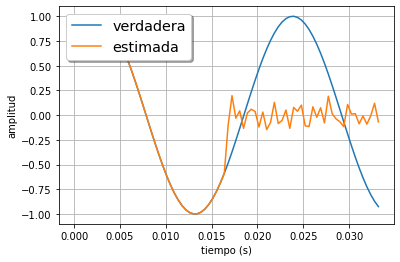

In [ ]:
# Podemos mirar individualmente algunos ejemplos
fig, ax = plt.subplots()

ts_fc = ts[:2*seq_len]
i = 101


true_signal = np.concatenate((x[train_idxs][i],y[train_idxs][i]))
estimated_signal = np.concatenate((x[train_idxs][i],y_preds[i]))

ax.plot(ts_fc , true_signal,label='verdadera')
ax.plot(ts_fc , estimated_signal,label='estimada')

ax.set(xlabel='tiempo (s)', ylabel='amplitud')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

ax.grid()

plt.show()

In [ ]:
# Entrenamos con early stopping

# Valores iniciales para el early stopping
best_val_loss = 10000.0
best_train_loss = 10000.0
j = 0
epoch = 0
selected_model_state_dict = model.state_dict()

while ((epoch < n_epochs) and (j < patience)):
    train_loss = train(model, train_loader)
    validation_loss = test(model, validation_loader)
    
    if epoch%50 == 0:
        print('Epoca: {:02d}/{:02d}.............'.format(epoch, n_epochs), end=' ')
        print("Train loss: {:.4f}".format(train_loss), ", Validation loss: {:.4f}".format(validation_loss))
        
    if (validation_loss <= best_val_loss):
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = validation_loss
        selected_model_state_dict = model.state_dict()
        j = 0
    else:
        j += 1

    epoch += 1
        
print('La mejor Epoca fue {:03d}, Train loss: {:.4f}, Validation loss: {:.4f}'.format(
              best_epoch, best_train_loss, best_val_loss))

# Nos quedamos con el modelo con mejor valor de validación  
model.load_state_dict(selected_model_state_dict)

Epoca: 00/1500............. Train loss: 0.5025 , Validation loss: 0.4861
Epoca: 50/1500............. Train loss: 0.1633 , Validation loss: 0.1533
Epoca: 100/1500............. Train loss: 0.0693 , Validation loss: 0.0671
Epoca: 150/1500............. Train loss: 0.0236 , Validation loss: 0.0252
Epoca: 200/1500............. Train loss: 0.0157 , Validation loss: 0.0176
Epoca: 250/1500............. Train loss: 0.0137 , Validation loss: 0.0135
Epoca: 300/1500............. Train loss: 0.0089 , Validation loss: 0.0106
Epoca: 350/1500............. Train loss: 0.0077 , Validation loss: 0.0083
Epoca: 400/1500............. Train loss: 0.0044 , Validation loss: 0.0050
Epoca: 450/1500............. Train loss: 0.0038 , Validation loss: 0.0038
Epoca: 500/1500............. Train loss: 0.0032 , Validation loss: 0.0034
Epoca: 550/1500............. Train loss: 0.0038 , Validation loss: 0.0025
Epoca: 600/1500............. Train loss: 0.0017 , Validation loss: 0.0014
Epoca: 650/1500............. Train loss:

<All keys matched successfully>

### Revisando resultados finales en Train y Test

Finalmente evaluamos el desempeño del modelo mirando tanto la función de pérdida como las salidas del mismo (visualmente).

In [ ]:
# Evaluando el modelo en Train después de entrenar

model.eval()
# all_train_outputs = model(....)
all_train_outputs = model(all_train_inputs)
y_preds = np.squeeze(all_train_outputs.data.cpu().numpy())


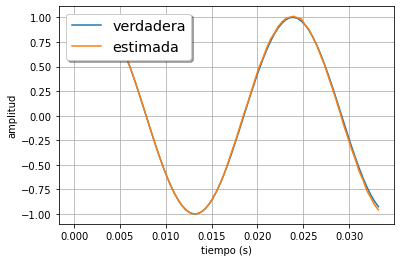

In [ ]:
# Volvemos a mirar individualmente algunos ejemplos
fig, ax = plt.subplots()

i = 101

true_signal = np.concatenate((x[train_idxs][i],y[train_idxs][i]))
estimated_signal = np.concatenate((x[train_idxs][i],y_preds[i]))

ax.plot(ts_fc , true_signal,label='verdadera')
ax.plot(ts_fc , estimated_signal,label='estimada')

ax.set(xlabel='tiempo (s)', ylabel='amplitud')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

ax.grid()

plt.show()

In [ ]:
# Y finalmente evaluamos en Test

model.eval()
all_test_inputs = torch.Tensor(x[test_idxs])
all_test_inputs = all_test_inputs.to(device)
all_test_outputs = model(all_test_inputs)
y_preds_test = all_test_outputs.data.cpu().numpy()
test_loss = test(model, test_loader)
print("Test loss =", test_loss)

Test loss = 0.0013447278033709154


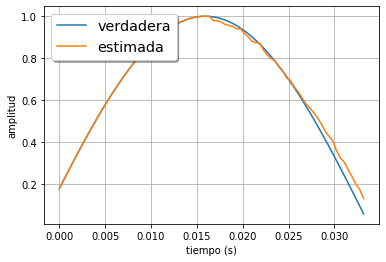

In [ ]:
# Inspección visual en test
fig, ax = plt.subplots()
i = 101

true_signal = np.concatenate((x[test_idxs][i],y[test_idxs][i]))
estimated_signal = np.concatenate((x[test_idxs][i],y_preds_test[i]))

ax.plot(ts_fc , true_signal,label='verdadera')
ax.plot(ts_fc , estimated_signal,label='estimada')

ax.set(xlabel='tiempo (s)', ylabel='amplitud')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

ax.grid()

plt.show()

## Parte b) Futuro Remoto

Ahora vamos a utilizar el mismo modelo **sin reentrenar**, para predecir las señales en el futuro remoto (z), a partir del pasado (x). Queremos evaluar la función de pérdida y la calidad de las predicciones sobre el conjunto de test correspondiente a este futuro remoto.

*Nota: No vale utilizar los valores verdaderos del futuro próximo (y) para calcular el futuro remoto (z)*

In [ ]:
# new_test_set = SignalDataset(x[test_idxs], z[test_idxs])
new_test_set = SignalDataset(y_preds_test, z[test_idxs])

new_test_loader = DataLoader(dataset=new_test_set, batch_size=batch_size, shuffle=False, num_workers=2)

model.eval()
# new_test_inputs = torch.Tensor(x[test_idxs])
new_test_inputs = torch.Tensor(y_preds_test)
new_test_inputs = new_test_inputs.to(device)
new_test_outputs = model(new_test_inputs)
z_preds_test = new_test_outputs.data.cpu().numpy()

new_test_loss = test(model, new_test_loader)
print("Futuro remoto. Test loss =", new_test_loss)


Futuro remoto. Test loss = 0.008116675983183086


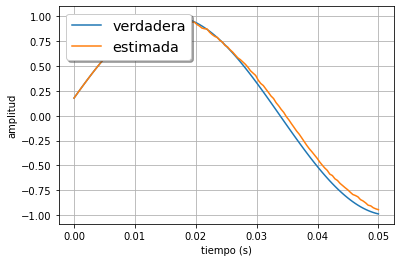

In [ ]:
# Inspección visual en test para el futuro remoto
fig, ax = plt.subplots()
i = 101

true_signal = np.concatenate((x[test_idxs][i],y[test_idxs][i],z[test_idxs][i]))
estimated_signal = np.concatenate((x[test_idxs][i],y_preds_test[i],z_preds_test[i]))

ax.plot(ts , true_signal,label='verdadera')
ax.plot(ts , estimated_signal,label='estimada')

ax.set(xlabel='tiempo (s)', ylabel='amplitud')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

ax.grid()

plt.show()